**Preliminary Data Exploration**

**Context on data used in this notebook**

The "train.csv" dataset contains tweets with correct sentiment labels. 

A ground truth value of 1 denoting positive sentiment of a tweet and a value of 0 denoting negative sentiment of a tweet.

The dataset also contains tweet sentiment predictions made by the PLStream model.

In [10]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,ground truth,text,prediction
0,1,Been going to Dr. Goldberg for over 10 years. ...,0
1,0,I don't know what Dr. Goldberg was like before...,0
2,0,I'm writing this review to give you a heads up...,0
3,1,All the food is great here. But the best thing...,1
4,0,Wing sauce is like water. Pretty much a lot of...,1


In [11]:
TP_count = len(df[(df['ground truth'] == 1) & (df['prediction'] == 1)])
print('Count of True Positives: %.0f' % TP_count)

TN_count = len(df[(df['ground truth'] == 0) & (df['prediction'] == 0)])
print('Count of True Negatives: %.0f' % TN_count)

FP_count = len(df[(df['ground truth'] == 0) & (df['prediction'] == 1)])
print('Count of False Positives: %.0f' % FP_count)

FN_count = len(df[(df['ground truth'] == 1) & (df['prediction'] == 0)])
print('Count of False Negatives: %.0f' % FN_count)

Count of True Positives: 145213
Count of True Negatives: 260081
Count of False Positives: 19045
Count of False Negatives: 135660


**Manually-calculated Confusion Matrix Metrics**

*   ***Accuracy:*** Overall, how often is the classifier correct? (TP+TN)/total
    
    0.7237406

*   ***Misclassification Rate/Error Rate:*** Overall, how often is it wrong?

    1 - accuracy = 0.2762594

*   ***True Positive Rate/Sensitivity/Recall:*** When it’s actually yes, how often does it predict yes? TP/(actual yes = TP+FN)

    0.5170059

*   ***False Positive Rate:*** When it’s actually no, how often does it predict yes? FP/(actual no = FP+TN)

    0.06823083

*   ***True Negative Rate/Specificity:*** When it’s actually no, how often does it predict no? TN/(actual no = FP+TN)

    0.9317692

*   ***Precision:*** When it predicts yes, how often is it correct? TP/predicted yes

    0.8840544

*   ***Prevalence:*** How often does the yes condition actually occur in our sample? (actual yes = TP+FN)/total

    0.5015598

**Random Forests Classifier**

We build this model to primarily to draw detailed insights on the performance of the PLStream classification model.

In [12]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0:1]
y = df.iloc[:, 2]
print(X.shape, y.shape)

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from sklearn.ensemble import RandomForestClassifier

# fit the model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

# make predictions
yhat = model.predict(X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, yhat)
print('Accuracy: %.3f' % acc)

(559999, 1) (559999,)
(391999, 1) (168000, 1) (391999,) (168000,)
Accuracy: 0.723


The PLStream model accuracy given by Random Forests is consistent with the results derived from our manually-calculated Confusion Matrix metrics.

**Confusion Matrix as calculated by Random Forests**

In [13]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test, yhat)
print(CM)

[[77820 40733]
 [ 5763 43684]]


**Accuracy of PLStream sentiment classification mode**

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77    118553
           1       0.52      0.88      0.65     49447

    accuracy                           0.72    168000
   macro avg       0.72      0.77      0.71    168000
weighted avg       0.81      0.72      0.74    168000



**Detection of binary class imbalance**

In [15]:
actual_positives_count = len(df[(df['ground truth'] == 1)])
print('Count of actual positives: %.0f' % actual_positives_count)

actual_negatives_count = len(df[(df['ground truth'] == 0)])
print('Count of actual negatives: %.0f' % actual_negatives_count)

predicted_positives_count = len(df[(df['prediction'] == 1)])
print('Count of predicted positives: %.0f' % predicted_positives_count)

predicted_negatives_count = len(df[(df['prediction'] == 0)])
print('Count of predicted negatives: %.0f' % predicted_negatives_count)

Count of actual positives: 280873
Count of actual negatives: 279126
Count of predicted positives: 164258
Count of predicted negatives: 395741


We find a binary class imbalance in our labelled train data as the number of positive tweet ground truths is a lot larger than the number of negative tweet ground truths.

Accuracy is not a great measure of model performance when the classes are imbalanced. 

So, to avoid inaccurate conclusions on model accuracy, we fix the binary class imbalance.

**METHOD 1: Fixing binary class imbalance using Random Under-Sampling**

In [16]:
df_pd0 = df[df['ground truth'] == 0]
df_pd1 = df[df['ground truth'] == 1]

#undersampling df_pd1,
import random
random.seed(100)
df_pd1_under = df_pd1.sample(actual_negatives_count)
new_df = pd.concat([df_pd0, df_pd1_under], axis = 0)
print(new_df.head())

print('Random under-sampling:')
print(new_df['ground truth'].value_counts())

   ground truth                                               text  prediction
1             0  I don't know what Dr. Goldberg was like before...           0
2             0  I'm writing this review to give you a heads up...           0
4             0  Wing sauce is like water. Pretty much a lot of...           1
5             0  Owning a driving range inside the city limits ...           0
6             0  This place is absolute garbage...  Half of the...           1
Random under-sampling:
0    279126
1    279126
Name: ground truth, dtype: int64


**Training Random Forests on the new data after Random Under-Sampling**

In [17]:
import pandas_datareader
from pandas_datareader import data

new_X = new_df.iloc[:, 0:1]
new_y = new_df.iloc[:, 2]

from sklearn.model_selection import train_test_split
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size = 0.3)

print(new_X_train.shape, new_X_test.shape, new_y_train.shape, new_y_test.shape)

from sklearn.ensemble import RandomForestClassifier

#fit the model
new_model = RandomForestClassifier()
new_model.fit(new_X_train, new_y_train)

# make predictions
new_yhat = new_model.predict(new_X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score
new_acc = accuracy_score(new_y_test, new_yhat)
print('New Accuracy: %.3f' % new_acc)

(390776, 1) (167476, 1) (390776,) (167476,)
New Accuracy: 0.723


In [18]:
from sklearn.metrics import confusion_matrix
new_CM = confusion_matrix(new_y_test, new_yhat)
print(new_CM)

[[77581 40529]
 [ 5836 43530]]


In [19]:
from sklearn.metrics import classification_report
print(classification_report(new_y_test, new_yhat))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77    118110
           1       0.52      0.88      0.65     49366

    accuracy                           0.72    167476
   macro avg       0.72      0.77      0.71    167476
weighted avg       0.81      0.72      0.74    167476



**METHOD 2: Fixing binary class imbalance using the SMOTE technique**

In [20]:
new_X = df.iloc[:, 0:1]
new_y = df.iloc[:, 2]

In [21]:
from sklearn.model_selection import train_test_split
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size = 0.3)

from imblearn.over_sampling import SMOTE

model = SMOTE()
smote_X_train, smote_y_train = model.fit_resample(new_X_train, new_y_train)

print(smote_X_train.shape, new_X_test.shape, smote_y_train.shape, new_y_test.shape)

(554140, 1) (168000, 1) (554140,) (168000,)


**Training Random Forests on the new data after applying SMOTE technique**

In [22]:
from sklearn.ensemble import RandomForestClassifier

#fit the model
new_model = RandomForestClassifier()
new_model.fit(new_X_train, new_y_train)

# make predictions
new_yhat = new_model.predict(new_X_test)
# evaluate predictions
from sklearn.metrics import accuracy_score
new_acc = accuracy_score(new_y_test, new_yhat)
print('New Accuracy: %.3f' % new_acc)

New Accuracy: 0.725


Even after balancing classes by random under-sampling and implementing SMOTE technique, we observe that the accuracy of the model remains unchanged. 

**ROC Curve** is a classification machine learning metric that is used to characterize the sensitivity/specificity tradeoffs of a binary classifier. 

In our case, we chose the Random Forests as our binary classifier.

Random Forest: AUROC = 0.772


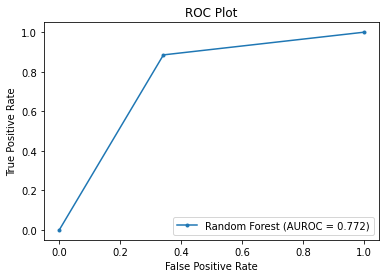

In [23]:
rf_probs = new_model.predict_proba(new_X_test) #prediction probabilities
rf_probs = rf_probs[:, 1] #only prediction probabilities of positive outcomes are selected

from sklearn.metrics import roc_curve, roc_auc_score
rf_auc = roc_auc_score(new_y_test, rf_probs)
print('Random Forest: AUROC = %.3f' % (rf_auc))

import matplotlib.pyplot as plt
rf_fpr, rf_tpr, _ = roc_curve(new_y_test, rf_probs)
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest (AUROC = %0.3f)' % rf_auc)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()

**AUC score** is the area under the ROC curve that represents a classification model's ability to predict classes correctly.

The higher the AUC score, the more accurate the model is at predicting the correct class. *As a good rule of thumb, an ROC AUC score of above 0.7 denotes good model performance.*

Our Random Forests classifier which we used to mimic and test the accuracy of PLStream predictions has an AUC score of 0.772. 

**Could we improve?**

AUC score can be improved by removing or adding more features that can help the model predict the right classes of tweet entries. In our case, it could be manipulating the list of positive and negative words. 

```
self.ref_pos = ['love', 'best', 'beautiful', 'great', 'cool', 'awesome', 'wonderful', 'brilliant', 'excellent', 'fantastic']

self.ref_neg = ['bad', 'worst', 'stupid', 'disappointing', 'terrible', 'rubbish', 'boring', 'awful', 'unwatchable', 'awkward']
```

The threshold values for classifying data points into classes can also be altered to enhance model performance and thereby increasing the AUC score.

```
cos_sim_bad - cos_sim_good < -0.5 # predicted positive
cos_sim_bad * self.neg_coefficient <= cos_sim_good * self.pos_coefficient # predicted positive

#cos_sim_bad - cos_sim_good > 0.5 # predicted negative
#cos_sim_bad * self.neg_coefficient >= cos_sim_good * self.pos_coefficient # predicted negative
```